## Introduction

This notebook aims to give you an extremely simple example of how to use Qlib RL. We will show you how to build up a simulator, a policy, and reward function. Then, we will show you how to run RL training & backtest workflows based on the aforementioned componenets.

This notebook assumes that you are aware of basic concepts of reinforcement learning. If you are unfamiliar with RL, please search for materials (for example, [Wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)) to get basic understanding of RL.

Let's start with the simulator.

## Simulator

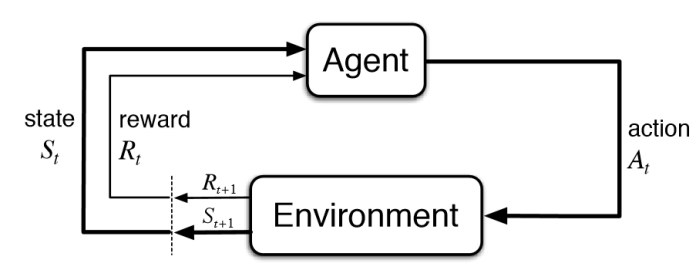

As stated in the above figure, environment is one of the two core componenets in the RL ecosystem. The operating logic of the environment is implemented in the **simulator**. In this notebook, we define a primitive simulator based on `qlib.rl.simulator.Simulator`:

In [ ]:
from collections import namedtuple
from typing import Any
from qlib.rl.simulator import Simulator

State = namedtuple("State", ["value", "last_action"])


class SimpleSimulator(Simulator[float, State, float]):
    def __init__(self, initial: float, nsteps: int, **kwargs: Any) -> None:
        super().__init__(initial)

        self.value = initial
        self.last_action = 0.0
        self.remain_steps = nsteps

    def step(self, action: float) -> None:
        assert 0.0 <= action <= self.value
        self.last_action = action
        self.remain_steps -= 1

    def get_state(self) -> State:
        return State(self.value, self.last_action)

    def done(self) -> bool:
        return self.remain_steps == 0

This simulator will run `nsteps` steps fixedly. It has a internal `value`, but this value will not be affected by the action. We will talk about what this property does later. The expected action from the agent should be a float number in the range of `[0.0, self.value]`. Each time the `step()` method is called, the simulator will record the action value, and wrap it into the simulator's state (see in `get_state()` method).

## Intepreters & Reward

There are three items in the process of interaction between environment and agent: **state**, **action**, and **reward**. Let's talk about state and action first. 

Environment and agent may represent state/action in different formats, so a "format converter" is needed between them. In Qlib RL, it is called **interpreter**. State interpreter takes states from the environment, and convert it to a format that agent could understand. Action interpreter works in the opposite direction. It takes actions from agent and convert it to a format that environment accepts.

As we mentioned when introducing the simulator, a state generated by the simulator is a tuple of two float numbers. The state interpreter is defined as follows:

In [ ]:
from typing import Tuple
import numpy as np
from gym import spaces
from qlib.rl.interpreter import StateInterpreter


class SimpleStateInterpreter(StateInterpreter[Tuple[float, float], np.ndarray]):
    def interpret(self, state: State) -> np.ndarray:
        # Convert state.value to a 1D Numpy array
        # last_action is not used by agents.
        return np.array([state.value], dtype=np.float32)

    @property
    def observation_space(self) -> spaces.Box:
        return spaces.Box(0, np.inf, shape=(1,), dtype=np.float32)


state_interpreter = SimpleStateInterpreter()

As for the action interpreter, in this notebook, we assume that the agent will not directly generate a float action. Instead, it generates a bucketized value (an integer) because we want to use a categorical model to build the policy. To be concrete, we divide `simulator.value` into N parts evenly, and the agent's action should be an integer in `[0, N]`. The value of this integer will be converted to the float number as follows:

In [ ]:
from qlib.rl.interpreter import ActionInterpreter


class SimpleActionInterpreter(ActionInterpreter[State, int, float]):
    def __init__(self, n_value: int) -> None:
        self.n_value = n_value

    @property
    def action_space(self) -> spaces.Discrete:
        return spaces.Discrete(self.n_value + 1)

    def interpret(self, simulator_state: State, action: int) -> float:
        assert 0 <= action <= self.n_value
        # simulator_state.value is used as the denominator
        return simulator_state.value * (action / self.n_value)


action_interpreter = SimpleActionInterpreter(n_value=10)

Finally, let's define the reward function. In this example, we use the proportion of `action` in `value` as the reward. In other words, the larger the action, the larger the reward:

In [ ]:
from qlib.rl.reward import Reward


class SimpleReward(Reward[State]):
    def reward(self, simulator_state: State) -> float:
        # Use last_action to calculate reward. This is why it should be in the state.
        rew = simulator_state.last_action / simulator_state.value
        return rew


reward = SimpleReward()

## Agent & Policy

The last thing we haven't talk about in the RL ecosystem is the agent. In RL, agents take actions follow particular policies, so defining agents is actually equivalent to defining policies. In this example, we define a PPO policy with a naive categorical neural network:

In [ ]:
from typing import List
import torch
from torch import nn
from qlib.rl.order_execution import PPO


class SimpleFullyConnect(nn.Module):
    def __init__(self, dims: List[int]) -> None:
        super().__init__()

        self.dims = [1] + dims
        self.output_dim = dims[-1]

        layers = []
        for in_dim, out_dim in zip(self.dims[:-1], self.dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU())
        self.fc = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.fc(x)


policy = PPO(
    network=SimpleFullyConnect(dims=[16, 8]),
    obs_space=state_interpreter.observation_space,
    action_space=action_interpreter.action_space,
    lr=0.01,
)

## Dataset

In order to get sufficient training data, usually we need to build multiple environments in parallel, and collect data from all these environments. To achieve that, we need to create multiple simulators with different initial settings. In Qlib RL, we could use a data set to implement this function:

In [ ]:
from torch.utils.data import Dataset


class SimpleDataset(Dataset):
    def __init__(self, positions: List[float]) -> None:
        self.positions = positions

    def __len__(self) -> int:
        return len(self.positions)

    def __getitem__(self, index: int) -> float:
        return self.positions[index]


dataset = SimpleDataset(positions=[10.0, 50.0, 100.0])

Each number in `positions` will be used to create a unique simulator. The creation of simulators will be handle by Qlib RL automatically. The only thing that developers need to do is defining the data set class and create a data set instance with data they want to use.

## Training workflow

Based on all the componenets we already have, it is super easy to launch a training workflow:

In [ ]:
from pathlib import Path
from typing import cast
from qlib.rl.trainer import Checkpoint, train

NSTEPS = 10

trainer_kwargs = {
    "max_iters": 10,
    "finite_env_type": "dummy",
    "callbacks": [
        Checkpoint(
            dirpath=Path("./checkpoints"),
            every_n_iters=1,
            save_latest="copy",
        )
    ],
}
vessel_kwargs = {
    "update_kwargs": {"batch_size": 16, "repeat": 5},
    "episode_per_iter": 50,
}

print("Training started")
train(
    simulator_fn=lambda position: SimpleSimulator(position, NSTEPS),
    state_interpreter=state_interpreter,
    action_interpreter=action_interpreter,
    policy=policy,
    reward=reward,
    initial_states=cast(List[float], SimpleDataset([10.0, 50.0, 100.0])),
    trainer_kwargs=trainer_kwargs,
    vessel_kwargs=vessel_kwargs,
)
print("Training finished")

## Backtest workflow

After the policy is trained, we could let it run in the environment and see its behaviors. This is called "backtest":

In [ ]:
from tianshou.data import Batch

simulator = SimpleSimulator(100.0, NSTEPS)
state = simulator.get_state()
obs = [{"obs": state_interpreter.interpret(state)}]
policy_out = policy(Batch(obs))
act = float(action_interpreter.interpret(state, policy_out.act))

simulator.step(act)
rew = float(reward(simulator.get_state()))

print(f"Action = {act:.6f}, Reward = {rew:.6f}.")